In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# This adds the parent directory (emotion-detection-wavelet) to the Python path
# so we can import from the 'src' folder.
sys.path.append(os.path.abspath(os.path.join('..')))

from src.data_loader import load_wesad_subject
from src.processing import wavelet_denoise, extract_rmssd_from_bvp

# Set a style for plots
plt.style.use('seaborn-v0_8-whitegrid')

In [14]:
# Define the path to your data file
DATA_PATH = '../data/raw/S10.pkl'

# Load the data using our custom function
data = load_wesad_subject(DATA_PATH)

if data:
    # Extract wrist signals and labels
    gsr_signal_raw = data['signal']['wrist']['EDA']
    bvp_signal_raw = data['signal']['wrist']['BVP']
    labels = data['label']
    print("Data loaded successfully.")

Data loaded successfully.


Original start index (at 700Hz): 2234999
Scaled start index (at 4Hz): 12771
Shape of the gsr_segment: (240,)


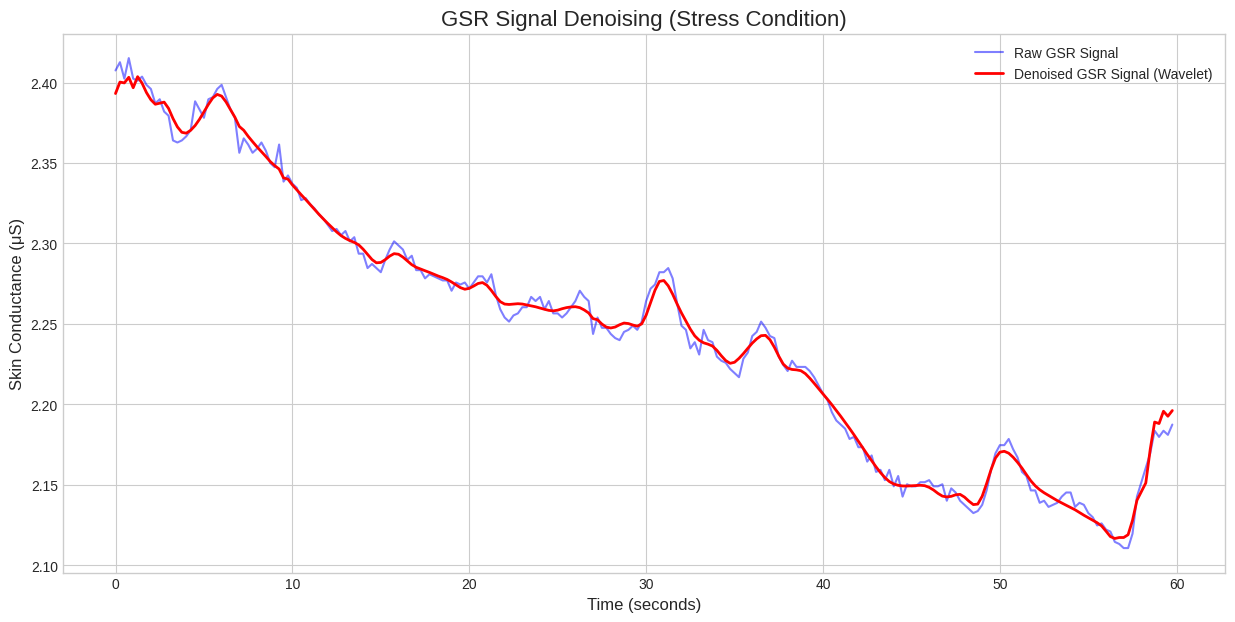

In [15]:
# --- Cell 3 (Corrected for Sampling Rate Mismatch) ---

# Find the start of the 'stress' condition in the high-frequency labels
label_sampling_rate = 700
stress_indices_labels = np.where(labels == 2)[0]

# --- Define the correct sampling rate for the wrist GSR/EDA sensor ---
gsr_sampling_rate = 4 # From WESAD documentation

if len(stress_indices_labels) > 0:
    # Get the start index from the labels
    start_index_labels = stress_indices_labels[0]
    
    # --- FIX: Scale the index to match the GSR signal's sampling rate ---
    scale_factor = gsr_sampling_rate / label_sampling_rate
    start_index_gsr = int(start_index_labels * scale_factor)

    # Now, slice the GSR signal using the correctly scaled index
    # We'll take a 60-second segment to ensure we have enough data at 4Hz
    duration_seconds = 60
    gsr_segment = gsr_signal_raw[start_index_gsr : start_index_gsr + (duration_seconds * gsr_sampling_rate)].flatten()
    
    print(f"Original start index (at 700Hz): {start_index_labels}")
    print(f"Scaled start index (at 4Hz): {start_index_gsr}")
    print(f"Shape of the gsr_segment: {gsr_segment.shape}")

    # Denoise the segment
    gsr_denoised = wavelet_denoise(gsr_segment)

    # --- Plot the results ---
    time_axis = np.arange(len(gsr_segment)) / gsr_sampling_rate

    plt.figure(figsize=(15, 7))
    plt.plot(time_axis, gsr_segment, label='Raw GSR Signal', color='blue', alpha=0.5)
    plt.plot(time_axis, gsr_denoised, label='Denoised GSR Signal (Wavelet)', color='red', linewidth=2)

    plt.title('GSR Signal Denoising (Stress Condition)', fontsize=16)
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Skin Conductance (μS)', fontsize=12)
    plt.legend(fontsize=10)
    plt.show()

else:
    print("No data points with the stress label '2' were found for this subject.")

In [16]:
# --- Cell 4: Feature Extraction ---
import pandas as pd
from src.feature_extraction import extract_gsr_features, extract_hrv_features

# We need a BVP segment that corresponds to our GSR segment
# First, let's get the denoised BVP segment
bvp_sampling_rate = 64
scale_factor_bvp = bvp_sampling_rate / label_sampling_rate
start_index_bvp = int(start_index_labels * scale_factor_bvp)
duration_seconds = 60 # Same duration as GSR

bvp_segment_raw = bvp_signal_raw[start_index_bvp : start_index_bvp + (duration_seconds * bvp_sampling_rate)].flatten()
bvp_denoised = wavelet_denoise(bvp_segment_raw)

# --- Extract features from both signals ---
gsr_features = extract_gsr_features(gsr_denoised, sampling_rate=gsr_sampling_rate)
hrv_features = extract_hrv_features(bvp_denoised, sampling_rate=bvp_sampling_rate)

# --- Combine and display the features ---
all_features = {**gsr_features, **hrv_features} # Merge the two dictionaries
feature_df = pd.DataFrame([all_features])

print("--- Extracted Features for the 'Stress' Segment ---")
display(feature_df)

--- Extracted Features for the 'Stress' Segment ---


,scr_count,mean_scr_amplitude,gsr_mean,gsr_std,gsr_range,mean_hr,rmssd,sdnn,pnn50
0,0,0,2.246813,0.080727,0.286918,63.479402,371.624594,314.907308,85.483871
